In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize   
from nltk.stem import WordNetLemmatizer 
import pyarrow
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from keras.preprocessing import sequence, text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from gensim.models.wrappers import FastText
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import  KeyedVectors
import gensim.downloader as api
from sklearn.tree import DecisionTreeClassifier
from gensim.models.fasttext import FastText as FT_trainable
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import  GlobalMaxPool1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.utils  import np_utils
import plotly.express as px
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from sklearn.decomposition import PCA

In [4]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/nlp"

Mounted at /content/drive


# **EDA**

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
train = pd.read_parquet('/content/drive/MyDrive/NLP1/train.parquet', engine = 'pyarrow')
test = pd.read_parquet('/content/drive/MyDrive/NLP1/test.parquet', engine = 'pyarrow')

In [7]:
def get_tag_keys(tag): #парсим символы тегов и отдельно кладем их в столбец TagsKeys
    
    if(not tag):
        return tag
    
    tag = tag.replace('><', ',')
    
    tag = tag.replace('<', '')
    
    tag = tag.replace('>', '')
    
    return tag

train['TagsKeys'] = train.Tags.apply(get_tag_keys)
test['TagsKeys'] = test.Tags.apply(get_tag_keys)

In [8]:
tag_keys = train.TagsKeys.to_list() #список всех тегов

In [9]:
tag_key_list   = []
tag_key_values = None
index_counter = 0
size = 0
tag_key_index_list = []

for item in tag_keys:
    item_parts = item.split(',')
    
    for item_ in item_parts:
        
        tag_key_index_list.append(index_counter)
        tag_key_list.append(item_)
        index_counter += 1
    
tag_key_new = pd.DataFrame({'id' : tag_key_index_list, 'tag_key' : tag_key_list }) # создаем фрейм с этими тегами и id

Text(0.5, 1.0, 'Часто встречаемые теги')

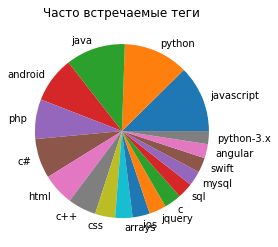

In [10]:
df_largest = tag_key_new.tag_key.value_counts().nlargest(18) #считаем количество каждого тега в фрейме и берем 18 часто встречаемых
keys = list(df_largest.keys())
counts = list(df_largest)
plt.pie(counts, labels=keys)
plt.title('Часто встречаемые теги')

Text(0.5, 1.0, 'Минимально встречаемые теги')

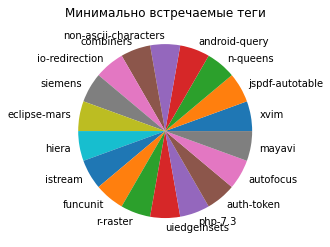

In [11]:
df_min = tag_key_new.tag_key.value_counts().nsmallest(18) #считаем количество каждого тега в фрейме и берем 18 мало встречаемых
keys = list(df_min.keys())
counts = list(df_min)
plt.pie(counts, labels=keys)
plt.title('Минимально встречаемые теги')

Text(0.5, 1.0, 'Target')

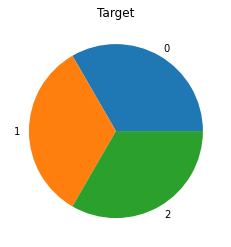

In [12]:
plt.pie([train.target[train.target == 0].count(),train.target[train.target == 1].count(),train.target[train.target == 2].count()],labels=['0','1','2'])
plt.title('Target')

In [13]:
def code_available(content): #смотрим присутствует ли код в боди
    
    if('<code>' in content):
        return 1
    
    return 0
train['code_available'] = train['Body'].apply(code_available)
test['code_available'] = test['Body'].apply(code_available)

In [14]:
train['Body'] = train['Title'] + " " + train['Body']+ " " + train['TagsKeys'] #соединяем body, title и теги  в один текст
test['Body'] = test['Title'] + " " + test['Body']+ " " + test['TagsKeys'] 

In [15]:
def remove_short_words(content):  #убираем слова длины меньше 4

    new_content_list = []
    for item in content:
        
        if(len(item) > 3):
            new_content_list.append(item)
    
    return " ".join(new_content_list)
train['Body'] =train['Body'].apply(lambda x:str(x).split())
train['Body'] = train['Body'].apply(remove_short_words)

test['Body'] = test['Body'].apply(lambda x:str(x).split())
test['Body'] = test['Body'].apply(remove_short_words)


In [16]:
def  clean_text(content): #чистим текст от символов, тегов и ненужных частей текста, приводим все к нижнему регистру
    
    content = content.lower()

    content = re.sub(r"(@[A-Za-z0-9]+)|^rt|http.+?", "", content)
    content = re.sub(r"(\w+:\/\/\S+)", "", content)
    content = re.sub(r"([^0-9A-Za-z \t])", " ", content)
    content = re.sub(r"^rt|http.+?", "", content)
    content = re.sub(" +", " ", content)
    content = re.sub(r"\d+", "", content)
    return content

train['Body'] = train['Body'].apply(clean_text)
test['Body'] = test['Body'].apply(clean_text)

In [17]:
stop_words = set(stopwords.words('english')) 

def remove_stopword(words):      #удаляем стоп слова
    list_clean = [w for w in words if not w in stop_words]
    return list_clean

train['Body'] =train['Body'].apply(lambda x:str(x).split())
train['Body'] = train['Body'].apply(remove_stopword)

test['Body'] = test['Body'].apply(lambda x:str(x).split())
test['Body'] = test['Body'].apply(remove_stopword)


In [18]:
  lemmer = WordNetLemmatizer() #лемматизация
  def lemmatizer_words(content):  

    new_content_list = []
    for item in content:
          new_content_list.append(lemmer.lemmatize(item)) 
    
    return new_content_list
  
train['Body'] = train['Body'].apply(lemmatizer_words)
test['Body'] = test['Body'].apply(lemmatizer_words)

In [19]:
train_data = train
test_data = test
target = train.target
train = train.drop(['Tags', 'Title','TagsKeys','code_available', 'target'], 
                   axis = 1)
test = test.drop(['Tags', 'Title','TagsKeys','code_available'], axis = 1)

In [20]:
def to_str(content): 

    new_content_list = []
    for item in content:
        
            new_content_list.append(item)
    
    return " ".join(new_content_list)
train['str'] = train['Body'].apply(to_str)
test['str'] = test['Body'].apply(to_str)

**One Hot Encoding**

In [ ]:
def count_number_tag(data):
  tags = dict()
  for i, row in tqdm.tqdm(data.iterrows()):
    
    current_tags = row["Tags"].split("<")
    for j in range(1,len(current_tags)):
      if current_tags[j][:-1] in tags:
        tags[current_tags[j][:-1]] += 1
      else:
        tags[current_tags[j][:-1]] = 1
  return tags

In [ ]:
train_tags = count_number_tag(train_data)

48000it [00:04, 10620.39it/s]


In [ ]:
def create_most_popular_tags(data, number_of_tags):
  most_popul_tags = dict()
  most_popul_tags = {k: v for k, v in reversed(sorted(data.items(), 
                                                      key=lambda item: item[1]))}
  labels = list()
  values = list()
  for i in range(len(most_popul_tags)):
    labels.append(list(most_popul_tags.keys())[i])
    values.append(most_popul_tags[list(most_popul_tags.keys())[i]])
    if i == number_of_tags:
      break
  return labels, values

In [ ]:
def one_hot_encoding_tags(dataset, count_tags, number_tags):
  most_popular_tags, _ = create_most_popular_tags(count_tags, number_tags)
  for i in most_popular_tags:
    dataset[i] =  pd.Series(np.zeros((len(dataset))), index=dataset.index) 
  for i, row in dataset.iterrows():
    current_tags = row["TagsKeys"].split(",")
    for j in current_tags:
      if j in dataset.columns:
        dataset[j][i] = 1
  return dataset

In [ ]:
train_ohe = one_hot_encoding_tags(train_data, train_tags, 200) 
test_ohe = one_hot_encoding_tags(test_data, train_tags, 200)
# в DataFrame находятся колонки с 200 тегами, а также колонка с отметкой, был ли в Body <code>, данный тэг помогает повысить accuracy на ~0.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
train_ohe = train_ohe.drop(['Body','Tags','Title','target','TagsKeys'], axis = 1)
test_ohe = test_ohe.drop(['Body','Tags','Title','TagsKeys'], axis = 1)

In [ ]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    train_ohe, 
    target, 
    test_size = 0.25, 
    random_state = 42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid = { 'n_neighbors': range(6, 20)}, cv = 5, n_jobs = -1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_  #(0.58, {'n_neighbors': 5})

knn = KNeighborsClassifier(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(knn.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(knn.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

*SVM*

In [ ]:
gs = GridSearchCV(SVC(), param_grid = {'gamma': [0.00001, 0.0001, 0.1, 1, 10, 100], 'C': range(1,5)}, n_jobs=-1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_  

svc = SVC(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(svc.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(svc.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

*Random Forest*

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), param_grid = { "criterion" : ["gini", "entropy"], "max_depth" : range(12,20,2), "n_estimators": range(100,1000,100)}, n_jobs=-1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_  #(0.5852291666666666, {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100})

md = RandomForestClassifier(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(md.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(md.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

*Decision tree*

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid = {'min_samples_leaf':range(20,100,5), 'min_samples_split':range(20,100,5), 'max_depth':range(2,50), 'criterion':['gini','entropy']}, n_jobs=-1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_  #(0.5852291666666666,{'criterion': 'gini','max_depth': 2,'min_samples_leaf': 20,'min_samples_split': 20})

md = DecisionTreeClassifier(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(md.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(md.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

*Boosting*

In [ ]:
gs = GridSearchCV(AdaBoostClassifier(),param_grid = {'n_estimators': range(50,1000,50)}, n_jobs=-1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_ 

md = AdaBoostClassifier(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(md.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(md.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

*Bagging*

In [ ]:
gs = GridSearchCV(BaggingClassifier(),param_grid = {'n_estimators': range(10,100,10)}, n_jobs=-1)
gs.fit(train_ohe, target)  
gs.best_score_, gs.best_params_ 

md = BaggingClassifier(**gs.best_params_).fit(X_train_ohe, y_train_ohe) 
acc = np.mean(md.predict(X_train_ohe) == y_train_ohe)
test_acc = np.mean(md.predict(X_test_ohe) == y_test_ohe)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.58, Test Accuracy: 0.58

**Вывод:** Все алгоритмы дали схожие результаты, их можно объяснить тем, что  достаточно сложно судить, к какой категории относится вопрос, рассматривая лишь его тэги 
В данном случае для того чтобы улучшить результат, мы посмотрели на наличие тега code внутри body, что уменьшило ошибку на 0.2

**Pre Word2Vec**

In [ ]:
def get_word2vec_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(" ".join(sentence))
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

In [ ]:
modelTwitter = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
train_word2vec_vectors = get_word2vec_vectors(train.str, modelTwitter)
test_word2vec_vectors = get_word2vec_vectors(test.str, modelTwitter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
train_word2vec_vectors  = pd.DataFrame(data=train_word2vec_vectors,index=train.index)
test_word2vec_vectors  = pd.DataFrame(data=test_word2vec_vectors,index=test.index)

In [ ]:
train_word2vec_vectors['code'] = train_data.code_available
test_word2vec_vectors['code'] = test_data.code_available

In [ ]:
X_train_word2vec_twitter, X_test_word2vec_twitter, y_train_word2vec_twitter, y_test_word2vec_twitter = train_test_split(train_word2vec_vectors, target, test_size = 0.25, random_state = 42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid = {'n_neighbors': range(6, 80)}, cv = 5, n_jobs = -1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_ 

md = KNeighborsClassifier(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.52, Test Accuracy: 0.48

*SVM*

In [ ]:
gs = GridSearchCV(SVC(), param_grid = {'gamma': [0.00001, 0.0001, 0.1, 1, 10, 100], 'C': range(1,5)}, n_jobs=-1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_  

md = SVC(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.53 Test Accuracy: 0.52

*Random Forest*

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), param_grid = { "criterion" : ["gini", "entropy"], "max_depth" : range(12,20,2), "n_estimators": range(100,1000,100)}, n_jobs=-1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_  

md = RandomForestClassifier(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.67

*Decision Tree*

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid = {
    'min_samples_leaf':range(20,100,5), 
    'min_samples_split':range(20,100,5), 
    'max_depth':range(2,50), 
    'criterion':['gini','entropy']}, 
    n_jobs=-1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_  

md = DecisionTreeClassifier(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.57

*Boosting*

In [ ]:
gs = GridSearchCV(AdaBoostClassifier(),param_grid = {
    'n_estimators': range(50,1000,50)}, 
    n_jobs=-1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_  

md = AdaBoostClassifier(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.65, Test Accuracy: 0.64

*Bagging*

In [ ]:
gs = GridSearchCV(BaggingClassifier(),param_grid = {
    'n_estimators': range(10,100,10)}, 
    n_jobs=-1)
gs.fit(train_word2vec_vectors, target)  
gs.best_score_, gs.best_params_  

md = BaggingClassifier(**gs.best_params_).fit(X_train_word2vec_twitter, y_train_word2vec_twitter) 
acc = np.mean(md.predict(X_train_word2vec_twitter) == y_train_word2vec_twitter)
test_acc = np.mean(md.predict(X_test_word2vec_twitter) == y_test_word2vec_twitter)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.98, Test Accuracy: 0.64

**Вывод:** Данная предобученная модель оказалась недостаточно подходящей для нашей задачи, так как вопросы на Stack Overflow более специфичные (технические), чем тексты, на которых обучалась модель

**Word2Vec**

In [28]:
def get_word2vec_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(" ".join(sentence))
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

In [29]:
model = Word2Vec(train.Body, size=300, min_count=5, window=5)  

In [32]:
train_word2vec = get_word2vec_vectors(train.Body, model)
test_word2vec = get_word2vec_vectors(test.Body, model)

In [31]:
train_word2vec = pd.DataFrame(data=train_word2vec,index=train.index)
test_word2vec = pd.DataFrame(data=test_word2vec,index=test.index)

In [ ]:
train_word2vec['code'] = train_data.code_available
test_word2vec['code'] = test_data.code_available

In [34]:
words = sorted(model.wv.vocab.keys(), 
               key=lambda word: model.wv.vocab[word].count,
               reverse=True)[:1000]

In [35]:
word_vectors = np.array([model.wv.get_vector(vector) for vector in words])

pca = PCA(n_components=2)
pca.fit(word_vectors)
word_vectors_pca = pca.transform(word_vectors)
word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(axis=0)) / word_vectors_pca.std(axis=0)

In [42]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blueviolet',
                 width=500, height=400, show=True, **kwargs):

    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [43]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1347', ...)

In [ ]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(train_word2vec, target, test_size = 0.25, random_state = 42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid = {
    'n_neighbors': range(6, 20, 2)}, 
    cv = 5, 
    n_jobs = -1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = KNeighborsClassifier(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.83, Test Accuracy: 0.75

*SVM*

In [ ]:
gs = GridSearchCV(SVC(), param_grid = {
    'gamma': [0.00001, 0.0001, 0.1, 1, 10, 100], 
    'C': range(1,5)}, 
    n_jobs=-1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = SVC(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.87, Test Accuracy: 0.859

*Random Forest*

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), param_grid = { 
    "criterion" : ["gini", "entropy"], 
    "max_depth" : range(12,20,2), 
    "n_estimators": range(100,1000,100)}, 
    n_jobs=-1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = RandomForestClassifier(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.84

*Decision tree*

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid = {
    'min_samples_leaf':range(20,100,5), 
    'min_samples_split':range(20,100,5), 
    'max_depth':range(2,50),
    'criterion':['gini','entropy']}, 
    n_jobs=-1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = DecisionTreeClassifier(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.73

*Boosting*

In [ ]:
gs = GridSearchCV(AdaBoostClassifier(),param_grid = {
    'n_estimators': range(50,1000,50)}, 
    n_jobs=-1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = AdaBoostClassifier(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.78, Test Accuracy: 0.78

*Bagging*

In [ ]:
gs = GridSearchCV(BaggingClassifier(),param_grid = {
    'n_estimators': range(10,100,10)}, 
    n_jobs=-1)
gs.fit(train_word2vec, target)  
gs.best_score_, gs.best_params_  

md = BaggingClassifier(**gs.best_params_).fit(X_train_word2vec, y_train_word2vec) 
acc = np.mean(md.predict(X_train_word2vec) == y_train_word2vec)
test_acc = np.mean(md.predict(X_test_word2vec) == y_test_word2vec)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.99, Test Accuracy: 0.81

**Вывод:** В данном случае мы получили лучший результат, так как векторное представление основывается на контекстной близости

**Pre Fast Text**

In [ ]:
def get_fasttext_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(" ".join(sentence))
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

In [ ]:
modelWiki = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/nlp/wiki.en.vec')

In [ ]:
train_fasttext_vectors = get_fasttext_vectors(train.Body, modelWiki)
test_fasttext_vectors = get_fasttext_vectors(test.Body, modelWiki)

In [ ]:
X_train_ft_wiki, X_test_ft_wiki, y_train_ft_wiki, y_test_ft_wiki = train_test_split(train_fasttext_vectors, target, test_size = 0.25, random_state = 42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid = {
    'n_neighbors': range(6, 20)}, 
    cv = 5, 
    n_jobs = -1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = KNeighborsClassifier(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.739, Test Accuracy: 0.63

*SVM*

In [ ]:
gs = GridSearchCV(SVC(), param_grid = {
    'gamma': [0.00001, 0.0001, 0.1, 1, 10, 100], 
    'C': range(1,5)}, 
    n_jobs=-1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = SVC(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.72, Test Accuracy: 0.708

*Random Forest*

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), param_grid = { 
    "criterion" : ["gini", "entropy"], 
    "max_depth" : range(12,20,2), 
    "n_estimators": range(100,1000,100)}, 
    n_jobs=-1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = RandomForestClassifier(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.66

*Decision tree*

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), param_grid = {
    'min_samples_leaf':range(20,100,5), 
    'min_samples_split':range(20,100,5), 
    'max_depth':range(2,48,2), 
    'criterion':['gini','entropy']}, 
    n_jobs=-1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = DecisionTreeClassifier(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 1.0, Test Accuracy: 0.50

*Boosting*

In [ ]:
gs = GridSearchCV(AdaBoostClassifier(),param_grid = {
    'n_estimators': range(50,1000,50)},
    n_jobs=-1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = AdaBoostClassifier(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.628 Test Accuracy: 0.619

*Bagging*

In [ ]:
gs = GridSearchCV(BaggingClassifier(),param_grid = {
    'n_estimators': range(10,100,10)}, 
    n_jobs=-1)
gs.fit(train_fasttext_vectors, target)  
gs.best_score_, gs.best_params_  

md = BaggingClassifier(**gs.best_params_).fit(X_train_ft_wiki, y_train_ft_wiki) 
acc = np.mean(md.predict(X_train_ft_wiki) == y_train_ft_wiki)
test_acc = np.mean(md.predict(X_test_ft_wiki) == y_test_ft_wiki)
print(f"Train Accuracy: {acc}, Test Accuracy: { test_acc}") #Train Accuracy: 0.98, Test Accuracy: 0.60

**Вывод:** Есть смысл сравнить с Pretrained Word2Vec, так как wiki-модель более обширная, чем twitter-модель, поэтому результаты здесь оказались лучше  


**Fast Text Own**

In [44]:
fasttext_train_samples = train['str'].to_list()
fasttext_train_samples = [x.split(' ') for x in fasttext_train_samples]

In [45]:
fasttext_test_samples = test['str'].to_list()
fasttext_test_samples = [x.split(' ') for x in fasttext_test_samples]

In [46]:
fasttext_sentences = fasttext_train_samples + fasttext_test_samples

In [47]:
our_FastText = FT_trainable(size=300)
our_FastText.build_vocab(sentences=fasttext_sentences)
our_FastText.train(
    sentences=fasttext_sentences, epochs=our_FastText.epochs,
    total_examples=our_FastText.corpus_count, 
    total_words=our_FastText.corpus_total_words
)

In [48]:
def get_fasttext_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(sentence)
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    vectorized = corpus.apply(lambda x: get_vector(x)).to_numpy()

    target = vectorized[0].shape[0]
    mismatches = {}
    for i in range(len(vectorized)):
      try:
        if vectorized[i].shape[0] != target:
          mismatches[i] = vectorized[i].shape[0]
      except Exception as e:
        mismatches[i] = str(e)
        continue
    print(mismatches)

    for i in mismatches.keys():
      vectorized = np.delete(vectorized, i)

    out_corpus = np.stack(vectorized)
    
    return out_corpus

In [49]:
own_ft_train_vectors = get_fasttext_vectors(train['str'], 
                                            our_FastText)

own_ft_test_vectors = get_fasttext_vectors(test['str'], 
                                           our_FastText)

{}
{}


In [50]:

words = sorted(model.wv.vocab.keys(), 
               key=lambda word: model.wv.vocab[word].count,
               reverse=True)[:1000]

In [51]:
word_vectors = np.array([model.wv.get_vector(vector) for vector in words])

pca = PCA(n_components=2)
pca.fit(word_vectors)
word_vectors_pca = pca.transform(word_vectors)
word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(axis=0)) / word_vectors_pca.std(axis=0)

In [52]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blueviolet',
                 width=500, height=400, show=True, **kwargs):

    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [53]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1480', ...)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    own_ft_train_vectors, 
    target, 
    test_size=0.25, 
    random_state=42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid={
    'n_neighbors': range(1, 20)}, 
    cv=5)
gs.fit(own_ft_train_vectors, target)
gs.best_score_, gs.best_params_

knn = KNeighborsClassifier(**gs.best_params_).fit(X_train, y_train)

acc_train = np.mean(knn.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(knn.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.89, Test Accuracy 0.84

*SVM*

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

acc_train = np.mean(clf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(clf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.88, Test Accuracy 0.87

*Random Forest*

In [ ]:
parameters = {'n_estimators': [5, 10, 15, 20, 25, 30], 
              'criterion': ['entropy', 'gini'],
              'max_depth': range(1, 20)
             }
gs = GridSearchCV(RandomForestClassifier(), parameters)
gs.fit(own_ft_train_vectors, target)
gs.best_score_, gs.best_params_

rdmf = RandomForestClassifier(**gs.best_params_)
rdmf.fit(X_train, y_train)

acc_train = np.mean(rdmf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(rdmf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 1.0, Test Accuracy 0.859

*Decision tree*

In [ ]:
parameters = {'criterion': ["gini", "entropy"], 
              'max_depth': range(1, 10),
              'min_samples_leaf': range(2, 10)
             }
gs = GridSearchCV(DecisionTreeClassifier(), parameters)
gs.fit(own_ft_train_vectors, target)
gs.best_score_, gs.best_params_

dtc = DecisionTreeClassifier(**gs.best_params_)
dtc.fit(X_train, y_train)

acc_train = np.mean(dtc.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(dtc.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 1.0, Test Accuracy 0.77

*Boosting*

In [ ]:
ada_boost = AdaBoostClassifier(dtc)
ada_boost.fit(X_train, y_train)

acc_train = np.mean(ada_boost.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(ada_boost.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.79, Test Accuracy 0.79

*Bagging*

In [ ]:
bclf = BaggingClassifier()
bclf.fit(X_train, y_train)

acc_train = np.mean(bclf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")

acc_test = np.mean(bclf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.99, Test Accuracy 0.83

**Вывод:** Результаты оказались близки к Word2Vec, но FastText оказался лучше

**TD-IDF**

In [ ]:
tf_idf = TfidfVectorizer()
tf_idf_vectors_train = tf_idf.fit_transform(train['str'])
tf_idf_vectors_test = tf_idf.transform(test['str'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vectors_train, target, test_size=0.2, random_state=42)

*KNN*

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid={ 
    'n_neighbors': range(1, 20)}, 
    cv=5)
gs.fit(tf_idf_vectors_train, target)
gs.best_score_, gs.best_params_ 

knn = KNeighborsClassifier(**gs.best_params_).fit(X_train, y_train)
acc_train = np.mean(knn.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(knn.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.73 Test Accuracy 0.61

*SVM*

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

acc_train = np.mean(clf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(clf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.97 Test Accuracy 0.81

*Random Forest*

In [ ]:
parameters = {'n_estimators': [5, 10, 15, 20, 25, 30], 
              'criterion': ['entropy', 'gini'],
              'max_depth': range(1, 20)
             }

gs = GridSearchCV(RandomForestClassifier(), parameters)
gs.fit(tf_idf_vectors_train, target)
gs.best_score_, gs.best_params_ 

rdmf = RandomForestClassifier(**gs.best_params_)
rdmf.fit(X_train, y_train)

acc_train = np.mean(rdmf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(rdmf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 1.0 Test Accuracy 0.80

*Decision tree*

In [ ]:
parameters = {'criterion': ["gini", "entropy"], 
              'max_depth': range(1, 10),
              'min_samples_leaf': range(2, 10)
             }

gs = GridSearchCV(DecisionTreeClassifier(), parameters)
gs.fit(tf_idf_vectors_train, target)
gs.best_score_, gs.best_params_ 
# 0.53, {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 7}

dtc = DecisionTreeClassifier(**gs.best_params_)
dtc.fit(X_train, y_train)

acc_train = np.mean(dtc.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(dtc.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 1.0 Test Accuracy 0.74

*Boosting*

In [ ]:
ada_boost = AdaBoostClassifier(dtc)
ada_boost.fit(X_train, y_train)

acc_train = np.mean(ada_boost.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(ada_boost.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.74 Test Accuracy 0.74

*Bagging*

In [ ]:
bclf = BaggingClassifier()
bclf.fit(X_train, y_train)

acc_train = np.mean(bclf.predict(X_train) == y_train)
print(f"Train Accuracy {acc_train}")
acc_test = np.mean(bclf.predict(X_test) == y_test)
print(f"Test Accuracy {acc_test}")

# Train Accuracy 0.99 Test Accuracy 0.78

**Вывод:** Данный алгоритм дал неплохие результаты, перед подсчетом мы думали,что данная модель окажется лучше остальных, так как от "важных" слов (слов с высоким приоритетом, например "советую/решил") может зависеть категория вопроса, но FastText  справился с заданной задачей лучше

**Нейронная сеть**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train.str.values, target, 
                                                  stratify=target, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [23]:
tokenizer = text.Tokenizer(num_words=None)
max_len = 70
tokenizer.fit_on_texts(list(X_train)+list(X_test)) #заполняем словарь
X_train_seq = tokenizer.texts_to_sequences(X_train) #преобразуем текст в последовательность чисел
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)#преобразуем к последовательностям одинаковой длины
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)
word_index = tokenizer.word_index

In [24]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, #добавляем ветктора
                     300,
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3)) #отсев
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) #добавляем слой short-term памяти

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax')) # активация
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #настройка модели для обучения
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           41575800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

In [25]:
y_train_enc = np_utils.to_categorical(y_train) #преобразуем вектор в матрицу
y_test_enc = np_utils.to_categorical(y_test)

In [26]:
import tensorflow   #callback для остановки тренировки
es = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
)
callbacks = [es]

In [27]:
history = model.fit(X_train_pad,y_train_enc, batch_size=512, epochs=40, verbose=1, validation_data=(X_test_pad, y_test_enc),callbacks=callbacks)

Epoch 1/40
85/85 [==============================] - 135s 2s/step - loss: 0.6357 - accuracy: 0.6691 - val_loss: 0.3838 - val_accuracy: 0.8263
Epoch 2/40
85/85 [==============================] - 141s 2s/step - loss: 0.4229 - accuracy: 0.8100 - val_loss: 0.3288 - val_accuracy: 0.8506
Epoch 3/40
85/85 [==============================] - 135s 2s/step - loss: 0.3851 - accuracy: 0.8299 - val_loss: 0.3123 - val_accuracy: 0.8600
Epoch 4/40
85/85 [==============================] - 136s 2s/step - loss: 0.3636 - accuracy: 0.8407 - val_loss: 0.3118 - val_accuracy: 0.8660
Epoch 5/40
85/85 [==============================] - 136s 2s/step - loss: 0.3475 - accuracy: 0.8479 - val_loss: 0.2929 - val_accuracy: 0.8685
Epoch 6/40
85/85 [==============================] - 134s 2s/step - loss: 0.3411 - accuracy: 0.8518 - val_loss: 0.2841 - val_accuracy: 0.8752
Epoch 7/40
85/85 [==============================] - 135s 2s/step - loss: 0.3293 - accuracy: 0.8564 - val_loss: 0.2847 - val_accuracy: 0.8727
Epoch 8/40
85

In [ ]:
validate_seq = tokenizer.texts_to_sequences(test.str.values)
validate_pad = sequence.pad_sequences(validate_seq, maxlen=max_len)
predictions = model.predict(validate_pad)
predictions = predictions.argmax(axis=1)
test['Predicted']=predictions
frame = test.drop(['Body','str'], axis= 1)
frame.to_csv('test.csv')

## **Результаты:**

Наилучший результат: accuracy: 0.9117, val_accuracy: 0.9075

При предварительной обработке данных с очисткой тэгов(<></>) точность составляла не более 0.75, если не убирать имена тэгов из текста, то точноcть составляет ~(0.80-0.90)